# 3.4 $\quad$ Optimización de carteras con posiciones cortas

Una **posición corta** se refiere a una estrategia de inversión donde se vende un activo que no se posee en ese momento con un pacto de recompra en el futuro. El vendedor espera beneficiarse de la caída del precio del activo. Veamos un ejemplo:

- `A` toma una posición corta sobre IBM de 500 acciones a `120$`, es decir, recibe  `60.000$` dólares.

- El Broker identifica un cliente `B` dispuesto a ser la contraparte.

- El cliente `B` entrega los `60.000$`.

- `A` se compromete a devolver el valor de las 500 acciones a `B` en julio

![Imagen del proyecto](https://drive.google.com/uc?id=1stsewRDNeW3AcpVyzIua2mDrKu1fAsei)


- En mayo se paga un dividendo de `1$`.

- `A` tiene que pagar `500$` al Broker por sus 500 acciones.

- El Broker paga al cliente `B` `500$`.

![Imagen del proyecto](https://drive.google.com/uc?id=1R7LAJd7wBhCHV9eU1yZXGvqM_ihWYAhJ)


- En julio, IBM cotiza a `100$`, el cliente `A` cierra su posición corta.

- `A` paga al Broker `100 x 500 = 50.000$`.

- El Broker paga al  `B` `50.000$`.

- Se cierra la posición corta.



![Imagen del proyecto](https://drive.google.com/uc?id=1oUtWVKzeZqA37KFOVdNXbqvBXuR6qx6I)


Como resultado de la operación corta obtenemos lo siguiente:

![Imagen del proyecto](https://drive.google.com/uc?id=1UbBnoY0NJW33AQ7vyND3olSP9RR3B7X1)


* Fuente: Hull (2018)

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cvxpy as cp
import yfinance as yf
import seaborn as sns
# import gurobipy as gp
# from gurobipy import GRB
from scipy.interpolate import interp1d

plt.style.use('ggplot')

In [ ]:
# Date range
start = '2015-01-01'
end = '2019-12-30'

# Assets todos con retornos positivos
assets = ['BA', 'BAX', 'BMY', 'CMCSA', 'CNP', 'CPB', 'DE', 'F', 'GE', 'HPQ',
        'JCI', 'JPM','KHC', 'LUV', 'MMC', 'MO', 'NI', 'PCAR', 'PSA', 'SEE',
        'T', 'TGT', 'TMO','TXT', 'VZ', 'ZION']


# Downloading data
prices = yf.download(assets, start=start, end=end, auto_adjust=True)["Close"]
prices.columns = assets

[*********************100%***********************]  26 of 26 completed


In [ ]:
#Número de activos
num_act = prices.shape[1]
returns = np.log(prices / prices.shift(1)).dropna()
matriz_cov = returns.cov().to_numpy() # Covariance matrix
retornos_esperados = returns.mean().to_numpy() # Column vector expected return

En primer lugar, vamos a definir la frontera eficiente de Markowitz sin posiciones cortas. Sin embargo, lo vamos a hacer de otra manera. En lugar de utilizar la aversión al riesgo, vamos a calcular:

1. La cartera de mínimo riesgo. Así, vemos el punto inicial de la frontera eficiente.
2. El riesgo del activo con máxima rentabilidad. Así, vemos el punto final de la frontera eficiente.
2. Modificando el riesgo, vamos calculando carteras con máxima rentabilidad para cada riesgo.

In [ ]:
# 1. Cartera de minimo riesgo

pesos = cp.Variable(num_act)
riesgo = cp.quad_form(pesos, matriz_cov)
ret = retornos_esperados @ pesos
objetivo = cp.Minimize(riesgo)

# Restricciones
constraints = [pesos >= 0,
               cp.sum(pesos) == 1
               ]

prob = cp.Problem(objetivo, constraints)

res = prob.solve()

min_ret = ret.value
min_riesgo = np.sqrt(riesgo.value) # Este es el punto inicial de la frontera eficiente

In [ ]:
# 2. Riesgo del activo de máxima rentabilidad
i_activo = np.argmax(retornos_esperados)
max_riesgo = np.sqrt(matriz_cov[i_activo, i_activo])

In [ ]:
# 3. Vamos a modificar el riesgo dando saltos equidistantes

retornos_res = []
riesgos_res = []
for riesgo_objetivo in np.linspace(min_riesgo, max_riesgo, 200):
    pesos = cp.Variable(num_act)
    riesgo = cp.quad_form(pesos, matriz_cov)
    ret = retornos_esperados @ pesos
    objetivo = cp.Maximize(ret)

    # Restricciones
    constraints = [pesos >= 0,
                   cp.sum(pesos) == 1,
                   riesgo <= riesgo_objetivo**2
                   ]

    prob = cp.Problem(objetivo, constraints)

    res = prob.solve()
    retornos_res.append(ret.value)
    riesgos_res.append(np.sqrt(riesgo.value))

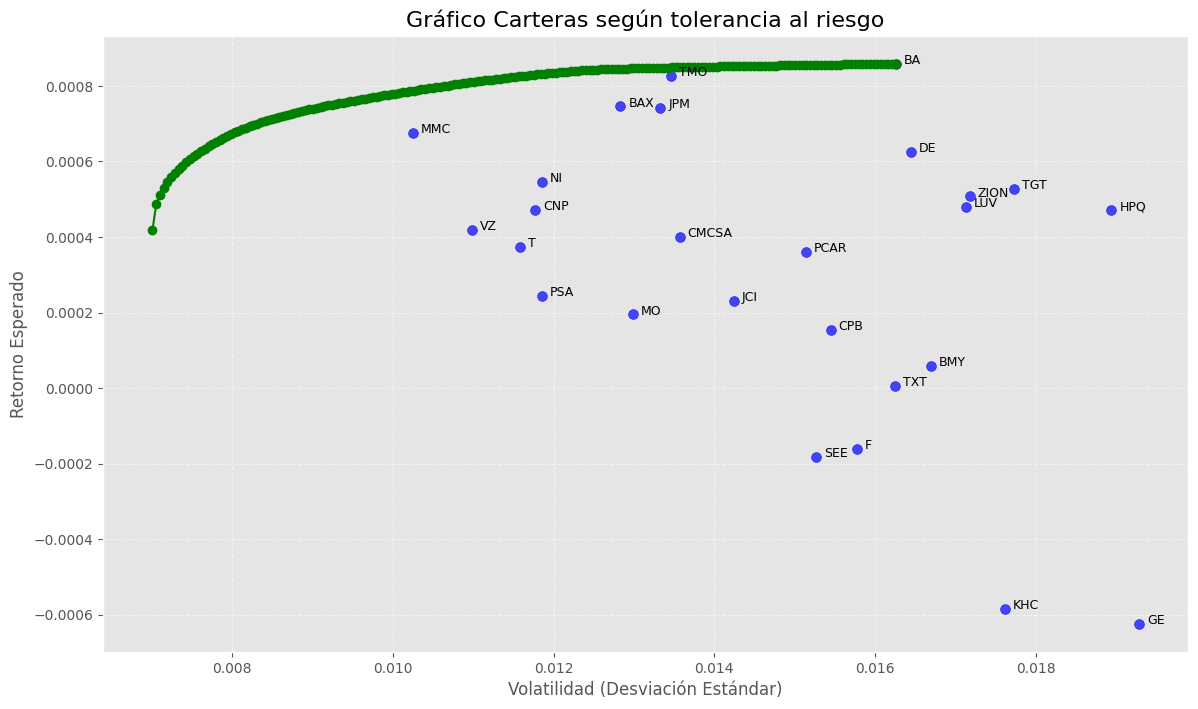

In [ ]:
# Estableciendo un tamaño y estilo para el gráfico
plt.figure(figsize=(14, 8))
plt.style.use('ggplot')

# Puntos de cada activo
plt.scatter(np.sqrt(np.diag(matriz_cov)), retornos_esperados, color='blue', s=50, label='Activos', alpha=0.7)

# Añadiendo los nombres de los activos con un desplazamiento
desplazamiento_x = 0.0001  # Ajusta este valor según sea necesario
desplazamiento_y = 0.00002  # Ajusta este valor según sea necesario

for i, asset in enumerate(assets):
    plt.text(np.sqrt(matriz_cov[i, i]) + desplazamiento_x, retornos_esperados[i] , asset, fontsize=9)

plt.plot(riesgos_res, retornos_res, '-o', color='green')#,  alpha=0.3)

# Añadiendo títulos y etiquetas
plt.title('Gráfico Carteras según tolerancia al riesgo', fontsize=16)
plt.xlabel('Volatilidad (Desviación Estándar)', fontsize=12)
plt.ylabel('Retorno Esperado', fontsize=12)

# Añadiendo leyenda con mejor posición
#plt.legend(loc='best')

# Mostrando la cuadrícula para mejor lectura
plt.grid(True, linestyle='--', alpha=0.5)

# Mostrar el gráfico
plt.show()


## 1. Carteras con posiciones cortas

### Carteras con posiciones cortas pero con límite de apalancamiento

El objetivo es calcular la cartera de máxima rentabilidad con un máximo en posiciones cortas, es decir, definiendo un límite máximo de apalancamiento (posición corta máxima). Primero, veamos las rentabilidades de cada uno de los activos:

Text(0.5, 1.0, 'Rentabilidad Esperada de los Activos')

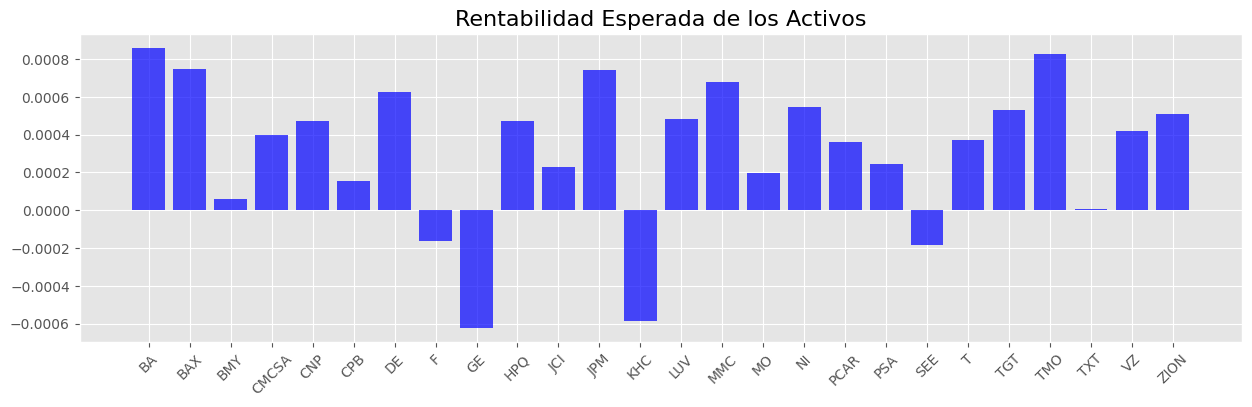

In [ ]:
plt.figure(figsize=(15, 4))

plt.bar(range(len(retornos_esperados)), retornos_esperados, color='blue', alpha=0.7)

# Añadiendo los nombres de los activos como etiquetas en el eje x
plt.xticks(range(len(assets)), assets, rotation=45)

plt.title('Rentabilidad Esperada de los Activos', fontsize=16)

## Ejercicio 1

Un inversor desea construir una cartera, **permitiendo posiciones largas y cortas**. El inversor impone una restricción de apalancamiento máximo del 200%. Calcula los pesos de la cartera y pintala en el grafico de retornos vs riesgos junto con los activos.

---

### Cartera de *máxima rentabilidad según tolerancia al riesgo* variando el límite de endeudamiento en corto permitido

## Ejercicio 2

Calcula la frontera eficiente para distintos niveles de apalancamiento y muestralo en la gráfica de retornos vs riesgos

In [ ]:
cortas_max = [1.0, 1.3, 1.5, 1.7, 2.0] # Máximo apalancamiento permitido
resultados_df = pd.DataFrame()
num_sim = 100

---

### Ejercicio 3:

Calcula la cartera de *máxima rentabilidad* limitando el riesgo a `0.014` y la posición en corto máxima en un activo al `20%`.

Calcula la **cartera equivalente pero sin posiciones cortas** para poder compararlas.